In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from currency_converter import CurrencyConverter

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline

# Load & prepare data
1. Load Car4You dataset
2. Load Kaggle dataset: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=skoda.csv
3. Merge datasets

In [3]:
df_car4you_raw = pd.read_csv('./data/car4you_suv_all_final.csv', delimiter=';')
df_car4you_raw.head()

,web-scraper-order,web-scraper-start-url,price_raw,marke_modell_raw,baujahr_km_treibstoff_getriebe_raw,properties_raw,garage_raw,garage_place_raw,description_raw
0,1652200447-14927,https://www.carforyou.ch/de/auto/suv?page=1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1652197876-3840,https://www.carforyou.ch/de/auto/suv?page=1667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1652201197-18131,https://www.carforyou.ch/de/auto/suv?page=1071,CHF 80’500,Audi Q5 Sportback 45 TFSI Black Edition quattr...,2021 · 2’900 km · Elektro/Benzin · Automatik,pricecheckMarktpreis,NaN,NaN,NaN
3,1652197512-2221,https://www.carforyou.ch/de/auto/suv?page=1734,CHF 39’990,Audi Q2 35 TDI quattro S-tronic,2020 · 10’000 km · Diesel · Automatik,pricecheckÜber dem Marktpreis,NaN,NaN,[YS] schwarz - felsgrau[GB1] LTE-Unterstützung...
4,1652204391-31474,https://www.carforyou.ch/de/auto/suv?page=515,CHF 73’000,Jaguar E-Pace 2.0 I4 200 R-Dynamic Black AWD,2022 · 45 km · Elektro/Benzin · Automatik,pricecheckÜber dem MarktpreisumbrellaKäuferschutz,Emil Frey Zürich Altstetten,"8048 Zürich, Zürich",NaN


In [4]:
from typing import Dict
import re


def extract_regex(pattern: str, target: str) -> str:
    """
    Helper method to extract regex from string
    :param pattern: The regex pattern
    :param target: The target to extract from
    :return: The extracted value, or NaN
    """
    if not pd.isnull(target) and re.search(pattern, target):
        return re.findall(pattern, target)[0]
    return np.NaN


def extract_manufacturer(cell_content) -> str:
    """
    Extract manufacturer by splitting the cell content and returning the first element
    :param cell_content: The cell content to extract manufacturer from
    :return: The manufacturer, or NaN
    """
    if not pd.isnull(cell_content):
        return cell_content.split(' ')[0]
    return np.NaN


def extract_year(cell_content: str) -> int:
    """
    Extract the year using a regex pattern
    :param cell_content: The cell content to extract year from
    :return: The extracted year, or NaN
    """
    year_str = extract_regex(r'[12][0-9]{3}', cell_content)
    return np.NaN if pd.isnull(year_str) else int(year_str)


def extract_km(cell_content: str) -> int:
    """
    Extract the km using a regex pattern
    :param cell_content: The cell content to extract km from
    :return: The extracted km value, or NaN
    """
    km_str = extract_regex(r'\d*’*\d+ km', cell_content)
    if pd.isnull(km_str):
        return np.NaN
    km = km_str.replace('’', '').replace(' km', '')
    return int(km)


def extract_fuel(cell_content: str) -> str:
    """
    Extract the fuel type from cell content
    :param cell_content: The cell content to extract values from
    :return: The fuel type, or NaN
    """
    if "Elektro/Benzin" in cell_content or "Elektro/Diesel" in cell_content:
        return "Hybrid"
    if "Benzin" in cell_content:
        return "Petrol"
    if "Diesel" in cell_content:
        return "Diesel"
    if "Elektro" in cell_content:
        return "Electric"

    return np.NaN

def extract_transmission(cell_content: str) -> str:
    """
    Extract transmission type from cell
    :param cell_content: The cell of which the value is extracted
    :return: The transmission type or NaN
    """
    if "Automatik" in cell_content:
        return "Automatic"
    if "Manuell" in cell_content:
        return "Manual"
    return np.NaN

def extract_price(cell_content: str) -> str:
    """
    Extract the price form the cell
    :param cell_content: The price cell content
    :return: The extracted price (str) or NaN
    """
    if pd.isnull(cell_content):
        return np.NaN
    return str(cell_content).replace('CHF ', '').replace('’', '')

def extract_price_check(cell_content: str) -> str:
    """
    Translate price check cell content to english lang
    :param cell_content: The price check cell content
    :return: The translated value
    """
    if "Über dem Marktpreis" in cell_content:
        return "Above market"
    if "Unter dem Marktpreis" in cell_content:
        return "Below market"
    if "Marktpreis" in cell_content:
        return "Market"
    return np.NaN

def row_to_dict(row: pd.Series) -> Dict:
    """
    Map one row of the DataFrame into a unified Dict
    :param row: The row to transform/map
    :return: The mapped dict
    """
    row_dict = {
        'manufacturer': extract_manufacturer(row[3]),
        'year': extract_year(str(row[4])),
        'km': extract_km(str(row[4])),
        'fuel': extract_fuel(str(row[4])),
        'transmission': extract_transmission(str(row[4])),
        'price': extract_price(row[2]),
        'price_check': extract_price_check(str(row[5])),
    }

    return row_dict


In [5]:
data_raw = []
for index, row in df_car4you_raw.iterrows():
    data_raw.append(row_to_dict(row))

df_car4you = pd.DataFrame(data_raw)
df_car4you.head()

,manufacturer,year,km,fuel,transmission,price,price_check
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Audi,2021.0,2900.0,Hybrid,Automatic,80500,Market
3,Audi,2020.0,10000.0,Diesel,Automatic,39990,Above market
4,Jaguar,2022.0,45.0,Hybrid,Automatic,73000,Above market


## Load Kaggle dataset

In [6]:
curr_converter = CurrencyConverter('./data/eurofxref.csv')


def load_kaggle_dataset(path: str, manufacturer: str) -> pd.DataFrame:
    """
    Load one kaggle dataset for given manufacturer
    :param path: The path to the dataset
    :param manufacturer: The manufacturer of the dataset content
    :return: A dataframe of the csv dataset
    """
    df_raw = pd.read_csv(path).drop(columns=['model', 'tax', 'tax(£)', 'mpg', 'engineSize'], errors='ignore')
    df_raw.insert(0, 'manufacturer', manufacturer)
    # assume market price for kaggle datasets
    df_raw['price_check'] = 'Market'
    df_raw.price = df_raw.price.apply(lambda x: curr_converter.convert(x, 'GBP', 'CHF'))
    df_raw.mileage = df_raw.mileage * 1.61
    return df_raw.rename(columns={'mileage': 'km', 'fuelType': 'fuel'})

In [7]:
df_audi = load_kaggle_dataset('./data/audi.csv', 'Audi')
df_bmw = load_kaggle_dataset('./data/bmw.csv', 'BMW')
df_merc_c_class = load_kaggle_dataset('./data/cclass.csv', 'Mercedes-Benz')
df_merc = load_kaggle_dataset('./data/merc.csv', 'Mercedes-Benz')
df_ford_focus = load_kaggle_dataset('./data/focus.csv', 'Ford')
df_ford = load_kaggle_dataset('./data/ford.csv', 'Ford')
df_hyundai = load_kaggle_dataset('./data/hyundi.csv', 'Hyundai')
df_skoda = load_kaggle_dataset('./data/skoda.csv', 'Skoda')
df_toyota = load_kaggle_dataset('./data/toyota.csv', 'Toyota')
df_vauxhall = load_kaggle_dataset('./data/vauxhall.csv', 'Vauxhall')
df_vw = load_kaggle_dataset('./data/vw.csv', 'VW')

In [8]:
# Concat all dataframes to a single one
df_raw = pd.concat([df_car4you, df_audi, df_bmw, df_merc_c_class, df_merc, df_ford_focus, df_ford, df_hyundai, df_skoda, df_toyota, df_vauxhall, df_vw])
df_raw.head()

,manufacturer,year,km,fuel,transmission,price,price_check
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Audi,2021.0,2900.0,Hybrid,Automatic,80500,Market
3,Audi,2020.0,10000.0,Diesel,Automatic,39990,Above market
4,Jaguar,2022.0,45.0,Hybrid,Automatic,73000,Above market


# Data cleansing


In [9]:
# Remove rows with NaN for better analysis:
print(f'Length before dropna(): {len(df_raw)}')
df_raw = df_raw.dropna()
print(f'Length after dropna(): {len(df_raw)}')

Length before dropna(): 152437
Length after dropna(): 121524


In [10]:
# For better analysis set data types
df = df_raw.astype({
    'manufacturer': 'category',
    'year': 'int32',
    'km': 'float',
    'fuel': 'category',
    'transmission': 'category',
    'price':'float',
    'price_check': 'category'
})
df.head()

,manufacturer,year,km,fuel,transmission,price,price_check
2,Audi,2021,2900.0,Hybrid,Automatic,80500.0,Market
3,Audi,2020,10000.0,Diesel,Automatic,39990.0,Above market
4,Jaguar,2022,45.0,Hybrid,Automatic,73000.0,Above market
7,VW,2021,23336.0,Petrol,Automatic,29900.0,Market
9,BMW,2019,20400.0,Diesel,Automatic,36900.0,Market


## Check for duplicates

In [11]:
search = pd.DataFrame.duplicated(df)
print(search.value_counts())
df[search == True]

False    110608
True      10916
dtype: int64


,manufacturer,year,km,fuel,transmission,price,price_check
246,Fiat,2015,105000.00,Petrol,Manual,12800.000000,Market
821,Mazda,2022,100.00,Petrol,Automatic,31490.000000,Above market
1369,Land,2018,90000.00,Diesel,Automatic,43990.000000,Market
2000,Jeep,2019,19900.00,Diesel,Automatic,29800.000000,Market
3316,Honda,2012,45000.00,Petrol,Manual,14800.000000,Market
...,...,...,...,...,...,...,...
14656,VW,2019,9660.00,Petrol,Semi-Auto,28050.420020,Market
14693,VW,2016,81750.97,Diesel,Manual,9759.691594,Market
14879,VW,2019,8050.00,Diesel,Automatic,36542.413206,Market
14890,VW,2019,8050.00,Diesel,Semi-Auto,32941.856899,Market


### Remove duplicates

In [12]:
print(f'Length of dataframe before removing duplicates: {len(df)}')
df = df[search == False]
print(f'Length of dataframe after removing duplicates: {len(df)}')

Length of dataframe before removing duplicates: 121524
Length of dataframe after removing duplicates: 110608


# Exploratory data analytics
With according measures

In [13]:
df.shape

(110608, 7)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110608 entries, 2 to 15156
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   manufacturer  110608 non-null  category
 1   year          110608 non-null  int32   
 2   km            110608 non-null  float64 
 3   fuel          110608 non-null  category
 4   transmission  110608 non-null  category
 5   price         110608 non-null  float64 
 6   price_check   110608 non-null  category
dtypes: category(4), float64(2), int32(1)
memory usage: 3.4 MB


In [15]:
df.isnull().sum()

manufacturer    0
year            0
km              0
fuel            0
transmission    0
price           0
price_check     0
dtype: int64

In [16]:
df.describe()

,year,km,price
count,110608.000000,110608.000000,110608.000000
mean,2017.144528,39157.875646,22759.751824
std,2.320959,35291.644679,15273.458357
min,1970.000000,1.000000,549.051284
25%,2016.000000,12673.920000,12805.096047
50%,2017.000000,29692.425000,18893.464724
75%,2019.000000,55138.072500,28050.420020
max,2060.000000,520030.000000,259900.000000


In [17]:
df[df.year > 2022]

,manufacturer,year,km,fuel,transmission,price,price_check
758,Land,2023,100.00,Petrol,Automatic,102540.000000,Market
2974,Jaguar,2023,10.00,Petrol,Automatic,97100.000000,Market
4503,Land,2023,45.00,Hybrid,Automatic,84200.000000,Market
13007,Jaguar,2023,20.00,Petrol,Automatic,94800.000000,Market
13609,Jaguar,2023,20.00,Petrol,Automatic,101860.000000,Above market
14801,Jaguar,2023,45.00,Petrol,Automatic,100060.000000,Above market
17771,Land,2023,45.00,Hybrid,Automatic,87060.000000,Market
19625,Land,2023,100.00,Petrol,Automatic,100600.000000,Market
22097,Jaguar,2023,18.00,Hybrid,Automatic,81940.000000,Above market
22367,Land,2023,15.00,Petrol,Automatic,108660.000000,Market


In [18]:
print(f'Length before removing invalid data: {len(df)}')
df = df[df.year <= 2022]
print(f'Length after removing invalid data: {len(df)}')

Length before removing invalid data: 110608
Length after removing invalid data: 110588


<AxesSubplot:title={'center':'Price check'}>

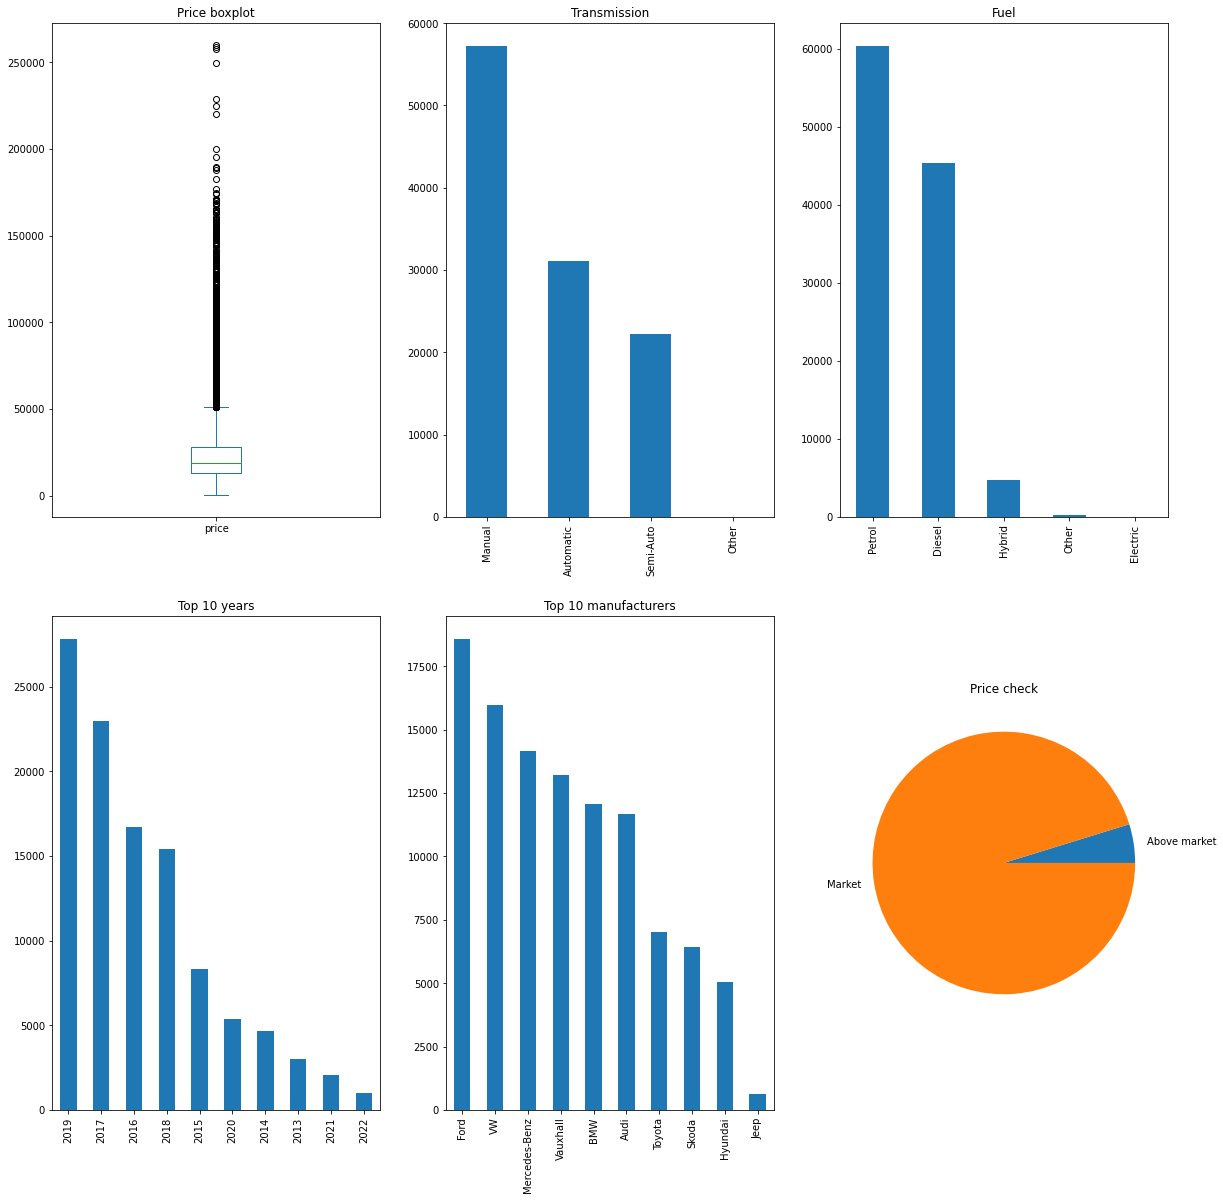

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
df.price.plot(kind='box', ax=axs[0, 0], title='Price boxplot')
df.manufacturer.value_counts()[:10].plot(kind='bar', ax=axs[1, 1], title='Top 10 manufacturers')
df.transmission.value_counts().plot(kind='bar', ax=axs[0, 1], title="Transmission")
df.fuel.value_counts().plot(kind='bar', ax=axs[0, 2], title="Fuel")
df.year.value_counts()[:10].plot(kind='bar', ax=axs[1, 0], title='Top 10 years')
df.groupby(df.price_check).size().plot(kind='pie', ax=axs[1, 2], title="Price check", ylabel="")

## Remove 'other' category

In [20]:
print(f'Lenght of Dataframe before "other" removal: {len(df)}')
df = df[df.fuel != 'Other']
df = df[df.transmission != 'Other']
df = df[df.manufacturer != 'Other']
print(f'Lenght of Dataframe before "other" removal: {len(df)}')

Lenght of Dataframe before "other" removal: 110588
Lenght of Dataframe before "other" removal: 110331


In [21]:
df_outliers = df[np.abs(stats.zscore(df.price) > 3)]
print(f'Outliers (row count = {len(df_outliers)}):')
df_outliers.head()

Outliers (row count = 2021):


,manufacturer,year,km,fuel,transmission,price,price_check
2,Audi,2021,2900.0,Hybrid,Automatic,80500.0,Market
4,Jaguar,2022,45.0,Hybrid,Automatic,73000.0,Above market
36,Porsche,2021,20900.0,Hybrid,Automatic,188000.0,Market
108,Mercedes-Benz,2016,118000.0,Petrol,Automatic,69900.0,Market
164,Porsche,2019,12500.0,Petrol,Automatic,83990.0,Market


In [22]:
print(f'Length of dataframe before outlier removal: {len(df)}')
df = df[~df.index.isin(df_outliers.index)]
print(f'Length of dataframe after outlier removal: {len(df)}')

Length of dataframe before outlier removal: 110331
Length of dataframe after outlier removal: 100714


<AxesSubplot:>

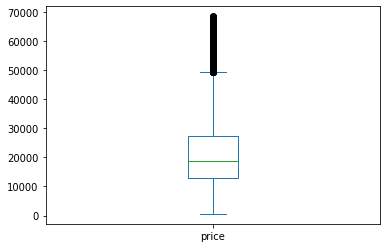

In [23]:
df.price.plot(kind = 'box')

<AxesSubplot:>

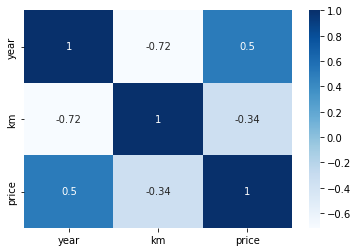

In [24]:
# TODO: make heatmap
corr = df.corr()

# plot the heatmap
sns.heatmap(corr,
            cmap="Blues",
            annot=True,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

[(0.0, 77098.2036026293)]

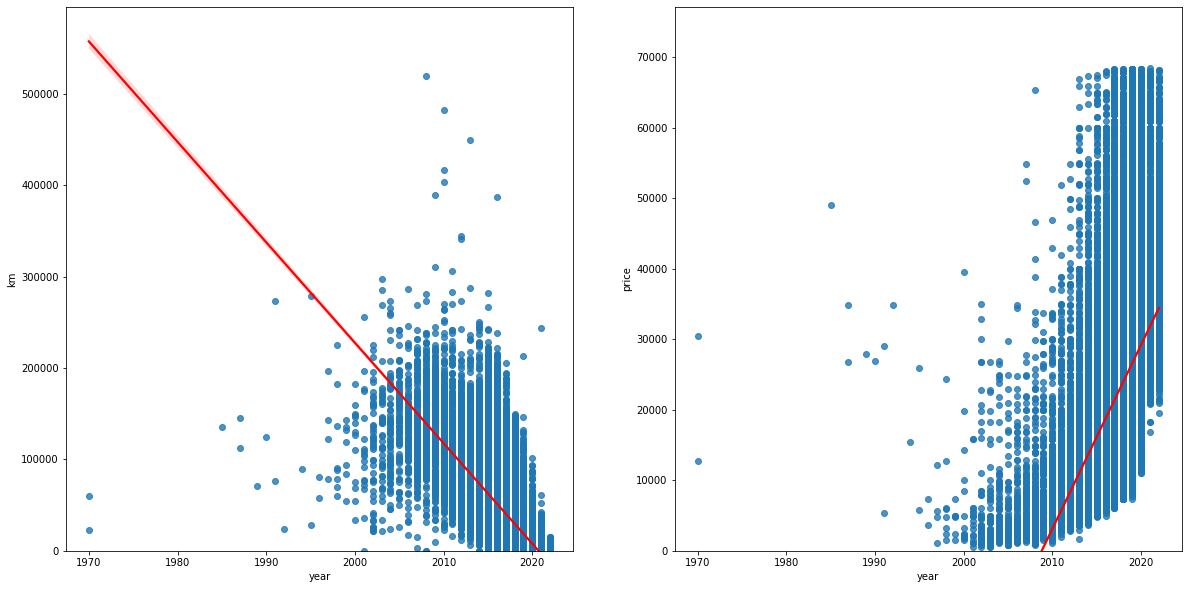

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
year_km = sns.regplot(data=df, x='year', y='km', ax=axs[0], line_kws={"color": "red"})
year_price = sns.regplot(data=df, x='year', y='price', ax=axs[1], line_kws={"color": "red"})
year_km.set(ylim=(0, None))
year_price.set(ylim=(0, None))

# Analysis and validation

c:\users\yvesh\.virtualenvs\data-science-22-car4you\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\yvesh\.virtualenvs\data-science-22-car4you\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\yvesh\.virtualenvs\data-science-22-car4you\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

<AxesSubplot:xlabel='km', ylabel='Density'>

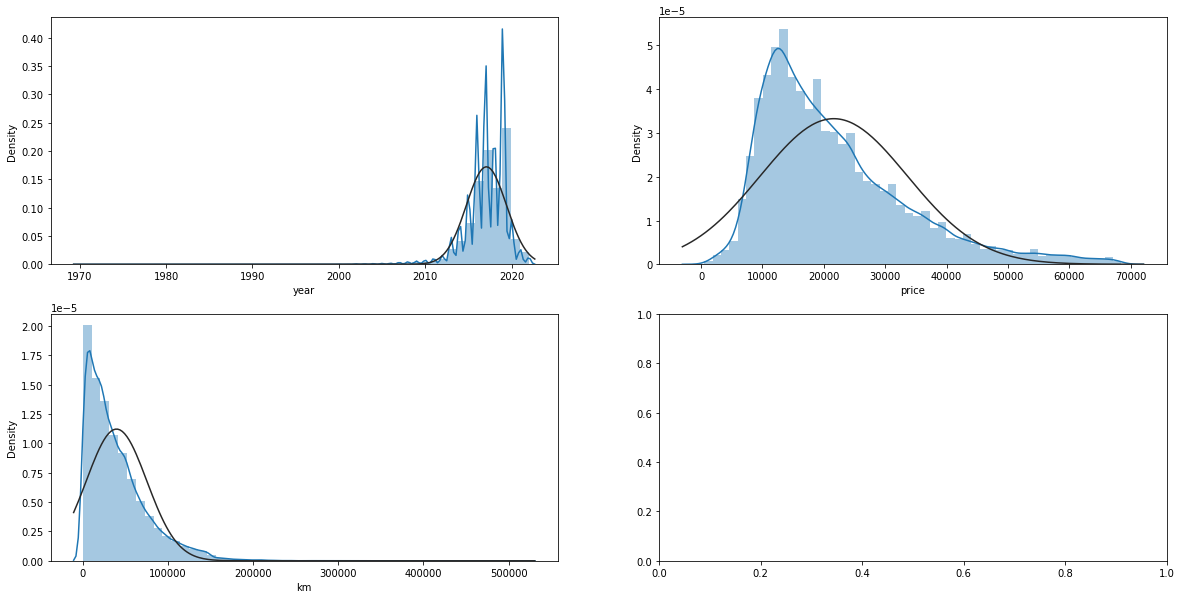

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

sns.distplot(df.year, fit=stats.norm, ax=axs[0, 0])
sns.distplot(df.price, fit=stats.norm, ax=axs[0,1])
sns.distplot(df.km, fit=stats.norm, ax=axs[1, 0])
# (Folowwing Dutli, D., 2020)

In [27]:
# remove years below 2005
print(f'Length of dataframe before year filtering: {len(df)}')
df = df[df.year >= 2005]
print(f'Length of dataframe after year filtering: {len(df)}')

Length of dataframe before year filtering: 100714
Length of dataframe after year filtering: 100489


In [28]:
# remove km outliers
df_km_outliers = df[np.abs(stats.zscore(df.km) > 3)]
print(f'Outliers (row count = {len(df_km_outliers)}):')
df_km_outliers.head()

Outliers (row count = 1313):


,manufacturer,year,km,fuel,transmission,price,price_check
33,Jeep,2011,146000.0,Diesel,Automatic,18900.0,Above market
291,Land,2008,149700.0,Diesel,Automatic,18900.0,Market
527,Audi,2012,150000.0,Petrol,Automatic,16999.0,Above market
859,Ford,2009,148000.0,Petrol,Manual,9900.0,Above market
863,Mercedes-Benz,2014,149980.0,Petrol,Automatic,17499.0,Above market


In [29]:
print(f'Length of dataframe before outlier (km) removal: {len(df)}')
df = df[~df.index.isin(df_km_outliers.index)]
print(f'Length of dataframe after outlier (km) removal: {len(df)}')

Length of dataframe before outlier (km) removal: 100489
Length of dataframe after outlier (km) removal: 93167


c:\users\yvesh\.virtualenvs\data-science-22-car4you\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\yvesh\.virtualenvs\data-science-22-car4you\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='km', ylabel='Density'>

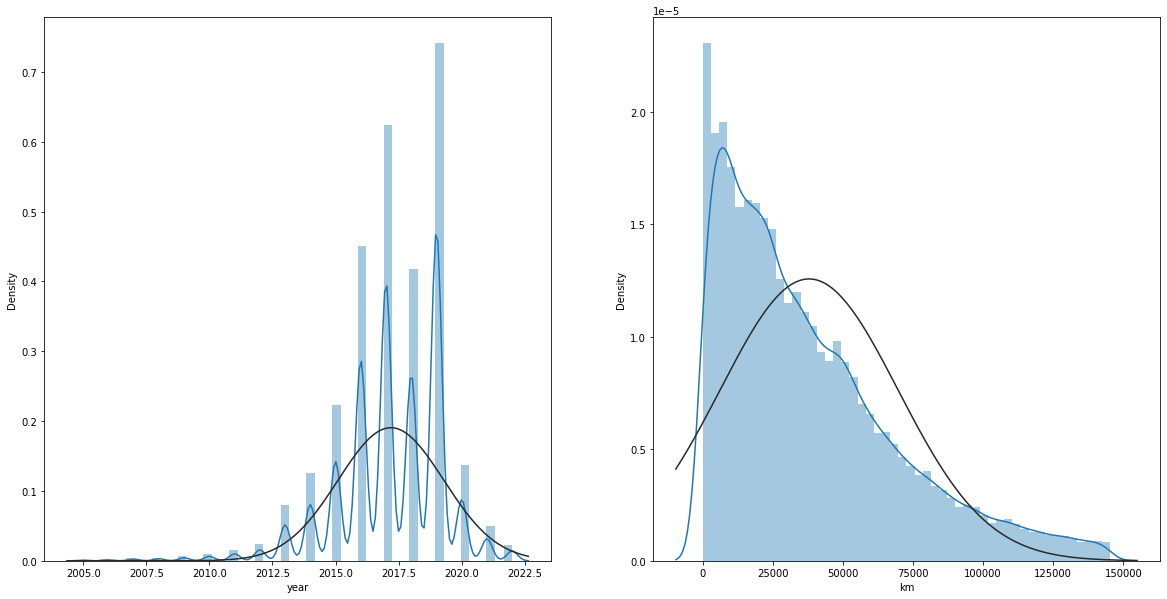

In [30]:
# Check distribution of year and km again:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

sns.distplot(df.year, fit=stats.norm, ax=axs[0])
sns.distplot(df.km, fit=stats.norm, ax=axs[1])
# (Folowwing Dutli, D., 2020)

# Data preparation

In [31]:
df_preped = df.copy()

In [32]:
df_preped.manufacturer = df_preped.manufacturer.cat.codes
df_preped.transmission = df_preped.transmission.cat.codes
df_preped.fuel = df_preped.fuel.cat.codes
df_preped.price_check = df_preped.price_check.cat.codes

In [33]:
X = df_preped.drop(columns='price')
y = df_preped.price

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21, stratify=df_preped.price_check)

# Feature selection

In [75]:
# feature selection using mutual_info_regression:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

def get_feature_scores(score_func) -> pd.DataFrame:
    select_best = SelectKBest(score_func=score_func, k='all')
    select_best = select_best.fit(X_train, y_train)
    return pd.DataFrame(dict(feature_names= X_train.columns , scores = select_best.scores_)).sort_values('scores',ascending = False)


In [76]:
mutual_feature_score = get_feature_scores(mutual_info_regression)
mutual_feature_score

,feature_names,scores
0,manufacturer,0.388544
1,year,0.329390
4,transmission,0.318788
2,km,0.162511
5,price_check,0.090078
3,fuel,0.070672


In [77]:
f_reg_feature_score = get_feature_scores(f_regression)
f_reg_feature_score

,feature_names,scores
1,year,26704.834296
2,km,8749.512610
3,fuel,3838.112218
0,manufacturer,3099.994982
5,price_check,2870.488773
4,transmission,165.521864


## Feature selection conclusion
Feature selection did not yield to any performance improvements

# Price prediction

In [78]:
class BenchmarkRegressor:
    def __init__(self):
        pass

    def fit(self, X, y, **kwargs):
        self.mean = y.mean()

    def predict(self, X):
        return [self.mean] * len(X)

    def get_params(self, deep=False):
        return {}

# The following Models are currently computing used the Standard Parameters. Please keep in mind,
# that they need to be optimized using the hyperparameters within the modeling process.

bm_regr = BenchmarkRegressor()
lr_regr = LinearRegression()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso()
en_regr = ElasticNet()
ne_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

models = [
    ('Benchmark', bm_regr),
    ('LR', lr_regr),
    ('Ridge', ri_regr),
    ('Bayesian Ridge', br_regr),
    ('Lasso', ls_regr),
    ('Elastic Net', en_regr),
    ('Nearest Neighbors (KNN) regression', ne_regr),
    ('Decision Tree', dt_regr),
    ('Random Forest', rf_regr),
    ('XGBoost', xg_regr),
]

In [79]:

for name, model in models:
    pipelined_model = Pipeline([
        ('pca', PCA(n_components = 3)),
        (name, model)
    ])

    # Training des Models
    pipelined_model.fit(X_train, y_train)

    # Vorhersage des trainierten models auf X_test
    y_hat = pipelined_model.predict(X_test)

    # Berechnung der verschiedenen Messwerte resp. KPI's
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
    R2 = r2_score(y_test, y_hat)
    print('Model: ', name, ' | EVS: ', EVS)
    print('Model: ', name, ' | ME: ', ME)
    print('Model: ', name, ' | MAE: ', MAE)
    print('Model: ', name, ' | MSE ', MSE)
    print('Model: ', name, ' | RMSE ', RMSE)
    print('Model: ', name, ' | R2 ', R2)
    print('----------------')

Model:  Benchmark  | EVS:  0.0
Model:  Benchmark  | ME:  46499.99196532882
Model:  Benchmark  | MAE:  9287.000933060352
Model:  Benchmark  | MSE  12015.802241561138
Model:  Benchmark  | RMSE  109.61661480615581
Model:  Benchmark  | R2  -2.1426390946599483e-05
----------------
Model:  LR  | EVS:  0.26056919623522323
Model:  LR  | ME:  56412.86127433262
Model:  LR  | MAE:  7633.236941764325
Model:  LR  | MSE  10332.390612022382
Model:  LR  | RMSE  101.64836748331172
Model:  LR  | R2  0.2605558226050526
----------------
Model:  Ridge  | EVS:  0.26056919232160836
Model:  Ridge  | ME:  56412.84227633637
Model:  Ridge  | MAE:  7633.237180010538
Model:  Ridge  | MSE  10332.390639091383
Model:  Ridge  | RMSE  101.64836761646191
Model:  Ridge  | R2  0.2605558187306314
----------------
Model:  Bayesian Ridge  | EVS:  0.26056889522483495
Model:  Bayesian Ridge  | ME:  56411.4399134572
Model:  Bayesian Ridge  | MAE:  7633.254941200363
Model:  Bayesian Ridge  | MSE  10332.39269457356
Model:  Bayesi

In [ ]:
results = []
names = []
for name, model in models:
    if 'Tree' in name or 'Forest' in name:
        # skip tree based models as they take very (very) long
        continue
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Benchmark: -0.000075 (0.000056)
LR: 0.413713 (0.007477)
Ridge: 0.413713 (0.007477)
Bayesian Ridge: 0.413713 (0.007476)
Lasso: 0.413712 (0.007474)
Elastic Net: 0.368650 (0.006017)
Nearest Neighbors (KNN) regression: 0.320314 (0.009954)


# Comparison
TODO
# Interpretation
TODO
